<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/Overlay_LST_on_Chicago_ECOSTRESS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     |████████████████████████████████| 18.1MB 47.5MB/s 


In [2]:
# Import necessary packages
import os, os.path
from glob import glob
from shutil import copyfile

import folium
from folium import plugins
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from matplotlib import colors as colors

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
files = glob("drive/My Drive/SatTemp/ECO2LSTE_2nd/*.tif")
print(files)

['drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2CLD.001_SDS_CloudMask_doy2019192112942_aid0001.tif', 'drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2CLD.001_SDS_CloudMask_doy2019194045909_aid0001.tif', 'drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_LST_doy2019192112942_aid0001.tif', 'drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_LST_doy2019194045909_aid0001.tif', 'drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_QC_doy2019192112942_aid0001.tif', 'drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_QC_doy2019194045909_aid0001.tif']


In [5]:
if not os.path.exists('geotiff'):
  os.mkdir('geotiff')

In [6]:
# copy these files from Google Drive to colab disk
for f in files:
  print(f)
  copyfile(f, 'geotiff/' + os.path.basename(f))

drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2CLD.001_SDS_CloudMask_doy2019192112942_aid0001.tif
drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2CLD.001_SDS_CloudMask_doy2019194045909_aid0001.tif
drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_LST_doy2019192112942_aid0001.tif
drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_LST_doy2019194045909_aid0001.tif
drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_QC_doy2019192112942_aid0001.tif
drive/My Drive/SatTemp/ECO2LSTE_2nd/ECO2LSTE.001_SDS_QC_doy2019194045909_aid0001.tif


In [7]:
# sorting will give us the files from June 1st 00 hour to June 3rd 23 hour
lst_files = glob("geotiff/*.tif")
lst_files.sort()
print(lst_files)

['geotiff/ECO2CLD.001_SDS_CloudMask_doy2019192112942_aid0001.tif', 'geotiff/ECO2CLD.001_SDS_CloudMask_doy2019194045909_aid0001.tif', 'geotiff/ECO2LSTE.001_SDS_LST_doy2019192112942_aid0001.tif', 'geotiff/ECO2LSTE.001_SDS_LST_doy2019194045909_aid0001.tif', 'geotiff/ECO2LSTE.001_SDS_QC_doy2019192112942_aid0001.tif', 'geotiff/ECO2LSTE.001_SDS_QC_doy2019194045909_aid0001.tif']


In [8]:
for file in lst_files:
  print(file.split('_'))
  print(file.split('_')[2] + '_' + file.split('_')[3])
#lst_files[num].split('_')[3] + '_' + lst_files[num].split('_')[4]

['geotiff/ECO2CLD.001', 'SDS', 'CloudMask', 'doy2019192112942', 'aid0001.tif']
CloudMask_doy2019192112942
['geotiff/ECO2CLD.001', 'SDS', 'CloudMask', 'doy2019194045909', 'aid0001.tif']
CloudMask_doy2019194045909
['geotiff/ECO2LSTE.001', 'SDS', 'LST', 'doy2019192112942', 'aid0001.tif']
LST_doy2019192112942
['geotiff/ECO2LSTE.001', 'SDS', 'LST', 'doy2019194045909', 'aid0001.tif']
LST_doy2019194045909
['geotiff/ECO2LSTE.001', 'SDS', 'QC', 'doy2019192112942', 'aid0001.tif']
QC_doy2019192112942
['geotiff/ECO2LSTE.001', 'SDS', 'QC', 'doy2019194045909', 'aid0001.tif']
QC_doy2019194045909


In [9]:
boundary = {}
raster = {}
nodata = {}
src_crs = {}

for file in lst_files:
  key = file.split('_')[2] + '_' + file.split('_')[3]
  with rio.open(file) as src:
    boundary[key] = src.bounds
    if 'LST' in key:
      raster[key] = (src.read() * .02) - 273.15
    else:
      raster[key] = src.read()
    nodata[key] = src.nodata
    src_crs[key] = src.crs

In [10]:
list(boundary.keys())

['CloudMask_doy2019192112942',
 'CloudMask_doy2019194045909',
 'LST_doy2019192112942',
 'LST_doy2019194045909',
 'QC_doy2019192112942',
 'QC_doy2019194045909']

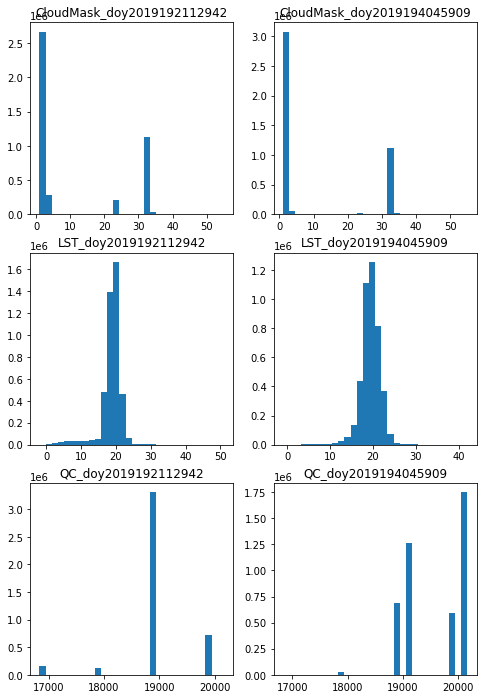

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
axs = list(flatten(axs))
keys = list(boundary.keys())

for ii in range(6):
  tmin = np.floor(np.nanmin(raster[keys[ii]]))
  tmax = np.ceil(np.nanmax(raster[keys[ii]]))
  axs[ii].hist(raster[keys[ii]].ravel(), bins=30, range=(tmin, tmax))
  axs[ii].set_title(keys[ii])
#plt.show()

In [21]:
def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.85)

uchicago_loc = [41.7886, -87.5987]

# Create a map using the Map() function and the coordinates for Chicago, IL
m = folium.Map(location=uchicago_loc, 
               tiles='Stamen Terrain', 
               zoom_start=14)

key = 'CloudMask_doy2019194045909'

# adjust the color map
import branca.colormap as cm
tmin = np.floor(np.nanmin(raster[key]))
tmax = 2 # np.ceil(np.nanmax(raster[key]))
#tmp_color = cm.linear.RdBu_11.colors
tmp_color = cm.linear.Greys_09.colors
#tmp_color.reverse()
colormap = cm.LinearColormap(
    colors = tmp_color, 
    vmin = tmin, 
    vmax = tmax)
print('Colormap range: ', tmin, tmax)

# overlay the raster
folium.raster_layers.ImageOverlay(
    image = raster[key][0],
    name = key,
    opacity = 0.7,
    pixelated = True,
    bounds = [[boundary[key].bottom, boundary[key].left], [boundary[key].top, boundary[key].right]],
    colormap= lambda value: mapvalue2color(value, colormap)
).add_to(m)

folium.Marker(uchicago_loc, popup='UChicago').add_to(m)

folium.LayerControl().add_to(m)
colormap.caption = 'MuSLI_LST'
m.add_child(colormap)

m


Colormap range:  1.0 2


In [17]:
import branca.colormap as cm
tmin = np.floor(np.nanmin(raster[key]))
tmax = np.ceil(np.nanmax(raster[key]))
tmp_color = cm.linear.Greys_09.colors
print(tmp_color)

[(1.0, 1.0, 1.0, 1.0), (0.9411764705882353, 0.9411764705882353, 0.9411764705882353, 1.0), (0.8509803921568627, 0.8509803921568627, 0.8509803921568627, 1.0), (0.7411764705882353, 0.7411764705882353, 0.7411764705882353, 1.0), (0.5882352941176471, 0.5882352941176471, 0.5882352941176471, 1.0), (0.45098039215686275, 0.45098039215686275, 0.45098039215686275, 1.0), (0.3215686274509804, 0.3215686274509804, 0.3215686274509804, 1.0), (0.1450980392156863, 0.1450980392156863, 0.1450980392156863, 1.0), (0.0, 0.0, 0.0, 1.0)]


In [ ]:
axs

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=3)

key = '2_11'
tmin = np.floor(np.nanmin(raster[key]))
tmax = np.ceil(np.nanmax(raster[key]))
plt.hist(raster[key].ravel(), bins=30, range=(tmin, tmax))
plt.show()

In [ ]:
# sorting will give us the files from June 1st 00 hour to June 3rd 23 hour
lst_files = glob("geotiff/*_LST_*.tif")
lst_files.sort()
print(lst_files)

['geotiff/MuSLI_LST_Chicago.201906010000.001.20201001083642.tif', 'geotiff/MuSLI_LST_Chicago.201906010100.001.20201001084921.tif', 'geotiff/MuSLI_LST_Chicago.201906010200.001.20201001090223.tif', 'geotiff/MuSLI_LST_Chicago.201906010300.001.20201001091528.tif', 'geotiff/MuSLI_LST_Chicago.201906010400.001.20201001092901.tif', 'geotiff/MuSLI_LST_Chicago.201906010500.001.20201001094243.tif', 'geotiff/MuSLI_LST_Chicago.201906010600.001.20201001095644.tif', 'geotiff/MuSLI_LST_Chicago.201906010700.001.20201001101112.tif', 'geotiff/MuSLI_LST_Chicago.201906010800.001.20201001102538.tif', 'geotiff/MuSLI_LST_Chicago.201906010900.001.20201001104034.tif', 'geotiff/MuSLI_LST_Chicago.201906011000.001.20201001105542.tif', 'geotiff/MuSLI_LST_Chicago.201906011100.001.20201001111111.tif', 'geotiff/MuSLI_LST_Chicago.201906011200.001.20201001112641.tif', 'geotiff/MuSLI_LST_Chicago.201906011300.001.20201001114247.tif', 'geotiff/MuSLI_LST_Chicago.201906011400.001.20201001115905.tif', 'geotiff/MuSLI_LST_Chica

In [ ]:
lst_files[10].split('.')[1][7] + '_' + lst_files[10].split('.')[1][8:10]

'1_10'

In [ ]:
boundary = {}
raster = {}
nodata = {}
src_crs = {}

for file in lst_files:
  key = file.split('.')[1][7] + '_' + file.split('.')[1][8:10]
  with rio.open(file) as src:
    boundary[key] = src.bounds
    raster[key] = src.read()
    nodata[key] = src.nodata
    src_crs[key] = src.crs

In [ ]:
#boundary
#nodata
#src_crs

In [ ]:
clat = (boundary[key].bottom + boundary[key].top)/2
clon = (boundary[key].left + boundary[key].right)/2
print(key, clat, clon)

3_23 41.80790530358678 -87.78840479684908


In [ ]:
import pandas as pd

# create a wide-form pandas
raster_df = pd.DataFrame()

In [ ]:
for key in raster.keys():
  raster_df[key] = raster[key].ravel()

raster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652120 entries, 0 to 652119
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   1_00    652120 non-null  float64
 1   1_01    652120 non-null  float64
 2   1_02    652120 non-null  float64
 3   1_03    652120 non-null  float64
 4   1_04    652120 non-null  float64
 5   1_05    652120 non-null  float64
 6   1_06    652120 non-null  float64
 7   1_07    652120 non-null  float64
 8   1_08    652120 non-null  float64
 9   1_09    652120 non-null  float64
 10  1_10    652120 non-null  float64
 11  1_11    652120 non-null  float64
 12  1_12    652120 non-null  float64
 13  1_13    632590 non-null  float64
 14  1_14    538919 non-null  float64
 15  1_15    593323 non-null  float64
 16  1_16    642421 non-null  float64
 17  1_17    652120 non-null  float64
 18  1_18    652120 non-null  float64
 19  1_19    629286 non-null  float64
 20  1_20    247209 non-null  float64
 21  1_21    33

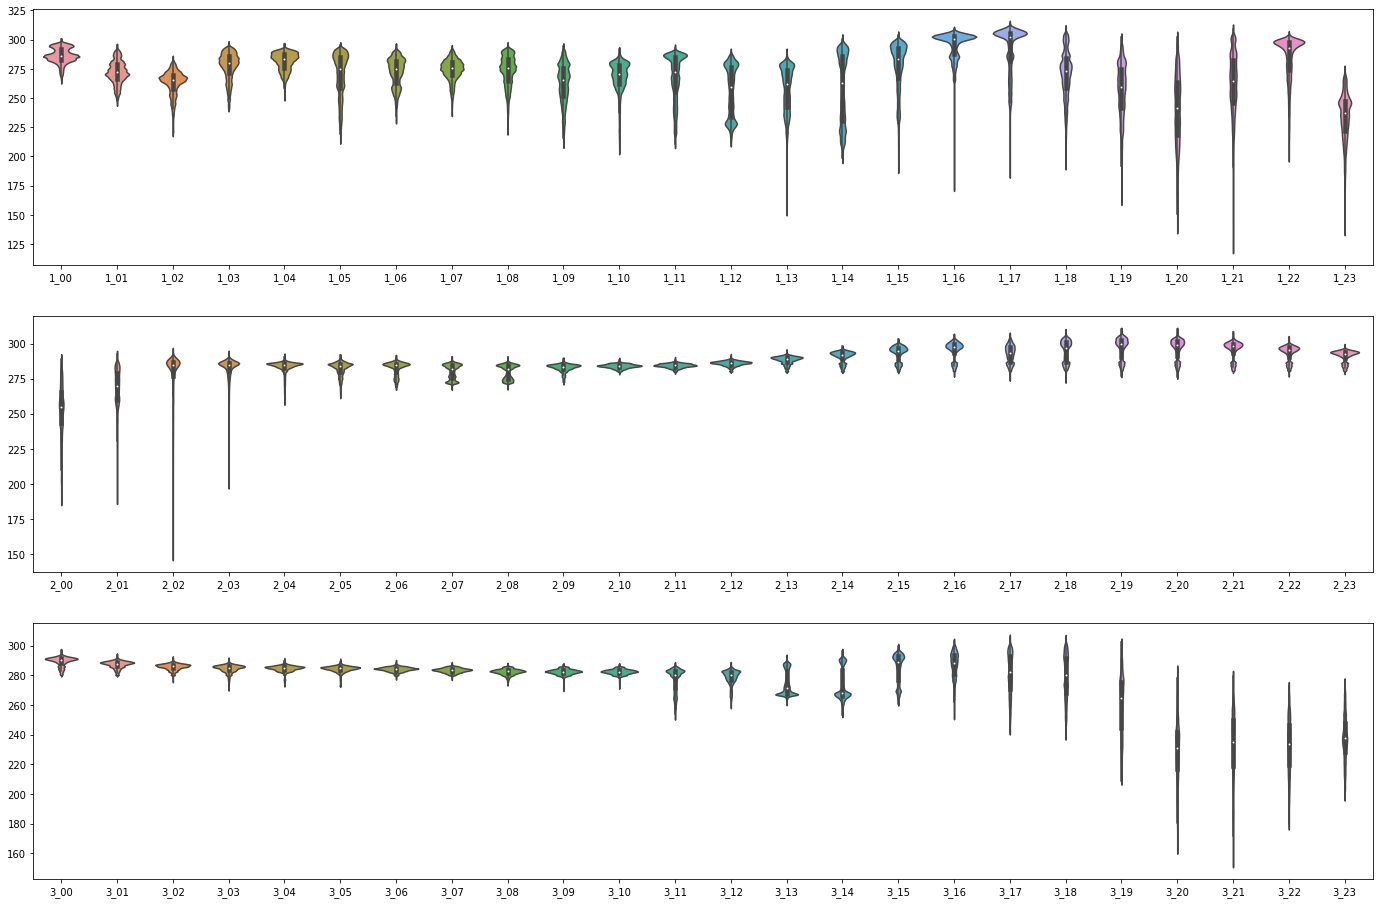

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(nrows=3, figsize=(24,16))

sns.violinplot(data=raster_df.iloc[:,0:24], ax=axs[0])
sns.violinplot(data=raster_df.iloc[:,24:48], ax=axs[1])
sns.violinplot(data=raster_df.iloc[:,48:72], ax=axs[2])

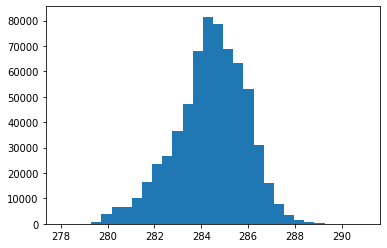

In [ ]:
key = '2_11'
tmin = np.floor(np.nanmin(raster[key]))
tmax = np.ceil(np.nanmax(raster[key]))
plt.hist(raster[key].ravel(), bins=30, range=(tmin, tmax))
plt.show()

In [ ]:
def mapvalue2color(value, cmap): 
    """
    Map a pixel value of image to a color in the rgba format. 
    As a special case, nans will be mapped totally transparent.
    
    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)    
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 0.85)

In [ ]:
#boundary
#src.bounds
#img.shape

In [ ]:
uchicago_loc = [41.7886, -87.5987]

# Create a map using the Map() function and the coordinates for Chicago, IL
m = folium.Map(location=uchicago_loc, 
               tiles='Stamen Terrain', 
               zoom_start=14)

key = '2_11'

# adjust the color map
import branca.colormap as cm
tmin = np.floor(np.nanmin(raster[key]))
tmax = np.ceil(np.nanmax(raster[key]))
tmp_color = cm.linear.RdBu_11.colors
colormap = cm.LinearColormap(
    colors = cm.linear.RdBu_11.colors, 
    vmin = tmin, 
    vmax = tmax)
print('Colormap range: ', tmin, tmax)

# overlay the raster
folium.raster_layers.ImageOverlay(
    image = raster[key][0],
    name = key,
    opacity = 0.7,
    pixelated = True,
    bounds = [[boundary[key].bottom, boundary[key].left], [boundary[key].top, boundary[key].right]],
    colormap= lambda value: mapvalue2color(value, colormap)
).add_to(m)

folium.Marker(uchicago_loc, popup='UChicago').add_to(m)

folium.LayerControl().add_to(m)
colormap.caption = 'MuSLI_LST'
m.add_child(colormap)

m


Colormap range:  278.0 291.0
